# In this notebook we make a customer torchgeo class for the Sentinel2 data as downloaded from Google Cloud 
Note that this currently takes the files in .jp2 format and will not search through a directory 

See prior notebook to download from cloud. 

I had some issues pulling from torchgeo on an M1 chip, I filed an issue with torchgeo https://github.com/microsoft/torchgeo/issues/438#issuecomment-1055868861 and this stack questions helped me fix my environment 
https://stackoverflow.com/questions/70830755/intel-mkl-fatal-error-this-system-does-not-meet-the-minimum-requirements-for-us 

Here we plot the NDWI and NDVI for Sentinel2, applied on the fly after sampling. Next step: to turn this into a preprocess step and append as a new channel.

As noted on SentinelHub:

Sentinel-2 NDWI = (B03 - B08) / (B03 + B08)

Sentinel2 NDVI = (B08 - B04) / (B08 + B04)

In [72]:
from typing import Any, Callable, Dict, Optional, Sequence

import matplotlib.pyplot as plt
import torch
from rasterio.crs import CRS
from torch import Tensor

from torchgeo.datasets import RasterDataset


import os
import tempfile

from torch.utils.data import DataLoader

from torchgeo.datasets import  stack_samples
# from torchgeo.datasets.utils import download_url7
from torchgeo.samplers import RandomGeoSampler

import numpy as np


In [21]:
class Sentinel(RasterDataset):
    """Abstract base class for all Sentinel datasets.

    `Sentinel <https://sentinel.esa.int/web/sentinel/home>`_ is a family of
    satellites launched by the `European Space Agency (ESA) <https://www.esa.int/>`_
    under the `Copernicus Programme <https://www.copernicus.eu/en>`_.

    If you use this dataset in your research, please cite it using the following format:

    * https://asf.alaska.edu/data-sets/sar-data-sets/sentinel-1/sentinel-1-how-to-cite/
    """


class Sentinel2(Sentinel):
    """Sentinel-2 dataset.

    The `Copernicus Sentinel-2 mission
    <https://sentinel.esa.int/web/sentinel/missions/sentinel-2>`_ comprises a
    constellation of two polar-orbiting satellites placed in the same sun-synchronous
    orbit, phased at 180° to each other. It aims at monitoring variability in land
    surface conditions, and its wide swath width (290 km) and high revisit time (10 days
    at the equator with one satellite, and 5 days with 2 satellites under cloud-free
    conditions which results in 2-3 days at mid-latitudes) will support monitoring of
    Earth's surface changes.
    """

    # TODO: files downloaded from USGS Earth Explorer seem to have a different
    # filename format than the official documentation
    # https://sentinels.copernicus.eu/web/sentinel/user-guides/sentinel-2-msi/naming-convention
    # https://sentinel.esa.int/documents/247904/685211/Sentinel-2-MSI-L2A-Product-Format-Specifications.pdf
    filename_glob = "T*B02.jp2"
    # filename_regex = r"""
    #     ^T(?P<tile>\d{2}[A-Z]{3})
    #     _(?P<date>\d{8}T\d{6})
    #     _(?P<band>B[018][\dA])
    #     _(?P<resolution>\d{2}m)
    #     \..*$
    # 
    filename_regex = r"""
    ^T(?P<tile>\d{2}[A-Z]{3})
    _(?P<date>\d{8}T\d{6})
    _(?P<band>B[018][\dA])
    \..*$
"""
    date_format = "%Y%m%dT%H%M%S"

    # https://gisgeography.com/sentinel-2-bands-combinations/
    all_bands = [
        "B01",
        "B02",
        "B03",
        "B04",
        "B05",
        "B06",
        "B07",
        "B08",
        "B8A",
        "B09",
        "B10",
        "B11",
        "B12",
    ]
    RGB_BANDS = ["B04", "B03", "B02"]

    separate_files = True
    def __init__(
        self,
        root: str = "data",
        crs: Optional[CRS] = None,
        res: Optional[float] = None,
        bands: Sequence[str] = [],
        transforms: Optional[Callable[[Dict[str, Any]], Dict[str, Any]]] = None,
        cache: bool = True,
    ) -> None:
        """Initialize a new Dataset instance.

        Args:
            root: root directory where dataset can be found
            crs: :term:`coordinate reference system (CRS)` to warp to
                (defaults to the CRS of the first file found)
            res: resolution of the dataset in units of CRS
                (defaults to the resolution of the first file found)
            bands: bands to return (defaults to all bands)
            transforms: a function/transform that takes an input sample
                and returns a transformed version
            cache: if True, cache file handle to speed up repeated sampling

        Raises:
            FileNotFoundError: if no files are found in ``root``
        """
        self.bands = bands if bands else self.all_bands

        super().__init__(root, crs, res, transforms, cache)


    def plot(  # type: ignore[override]
        self,
        sample: Dict[str, Tensor],
        show_titles: bool = True,
        suptitle: Optional[str] = None,
    ) -> plt.Figure:
            """Plot a sample from the dataset.

            Args:
                sample: a sample returned by :meth:`RasterDataset.__getitem__`
                show_titles: flag indicating whether to show titles above each panel
                suptitle: optional string to use as a suptitle

            Returns:
                a matplotlib Figure with the rendered sample

            Raises:
                ValueError: if the RGB bands are not included in ``self.bands``

            .. versionadded:: 0.3
            """
            rgb_indices = []
            for band in self.RGB_BANDS:
                if band in self.bands:
                    rgb_indices.append(self.bands.index(band))
                else:
                    raise ValueError("Dataset doesn't contain some of the RGB bands")

            image = sample["image"][rgb_indices].permute(1, 2, 0)
            image = torch.clamp(image / 3000, min=0, max=1)  # type: ignore[attr-defined]

            fig, ax = plt.subplots(1, 1, figsize=(4, 4))

            ax.imshow(image)
            ax.axis("off")

            if show_titles:
                ax.set_title("Image")

            if suptitle is not None:
                plt.suptitle(suptitle)

            return fig

In [ ]:
def normalize(x: np.ndarray, percentile: int = 100) -> np.ndarray:
    """Min/max normalize to [0, 1] range given a percentile."""
    c, h, w = x.shape
    x = x.reshape(c, -1)
    min = np.percentile(x, 100 - percentile, axis=-1)[:, None, None]
    max = np.percentile(x, percentile, axis=-1)[:, None, None]
    x = x.reshape(c, h, w)
    x = np.clip(x, min, max)
    return (x - min) / (max - min)

In [74]:
#path contains four .jp2 files for the four bands, path8 only contains band8
path = '/Users/gracecolverd/Documents/Fire_Proj/sentinel2/S2A_MSIL1C_20160911T092032_N0204_R093_T35UNU_20160911T092026.SAFE/GRANULE/L1C_T35UNU_A006382_20160911T092026/IMG_DATA'


In [23]:
ds = Sentinel2(path, bands=['B02', 'B03' , 'B04', 'B08'])


sampler = RandomGeoSampler(ds, size=1024, length=3)
dl = DataLoader(ds, sampler=sampler, collate_fn=stack_samples)

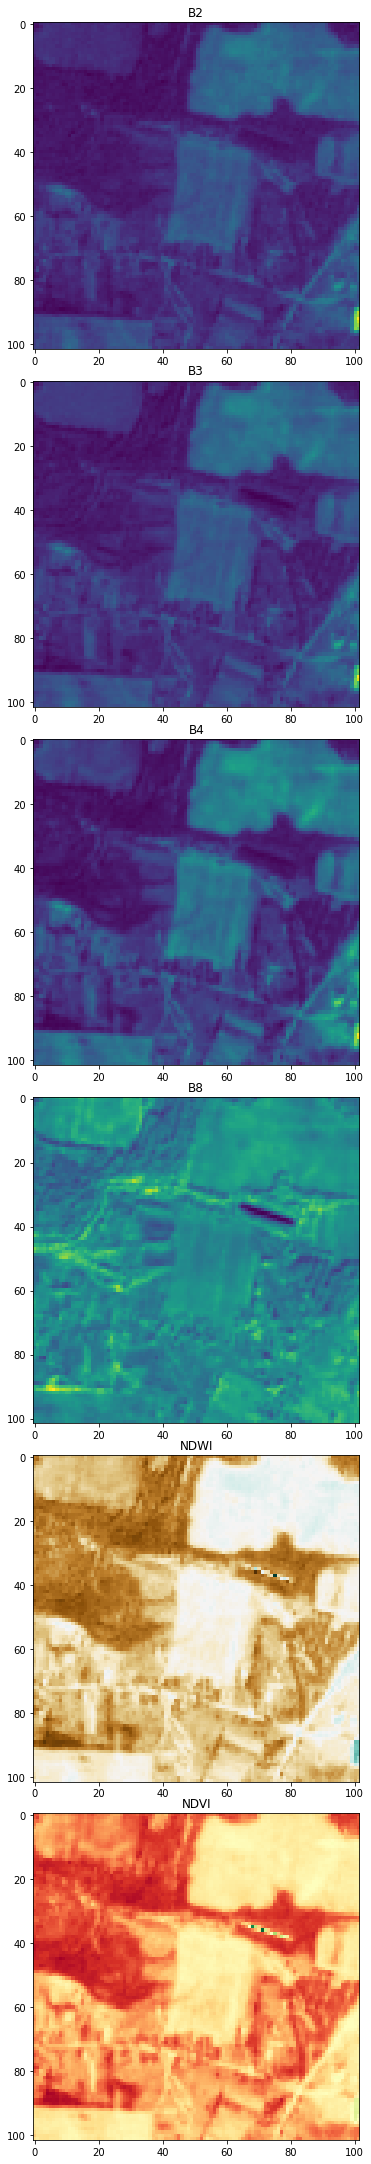

In [75]:
fig, ax = plt.subplots(6, figsize = (20,30) )
plt.tight_layout()

for sample in dl:

    image = sample['image']
    image = torch.squeeze(image)

    ax[0].imshow(image[0])
    ax[0].set_title('B2')
    
    ax[1].imshow(image[1])
    ax[1].set_title('B3')
    
    ax[2].imshow(image[2])
    ax[2].set_title('B4')
    
    ax[3].imshow(image[3])
    ax[3].set_title('B8')

    
    norm_im =normalize(image)

    b2 = norm_im[0]
    b3 = norm_im[1]
    b4 = norm_im[2]
    b8 = norm_im[3]
    
    
    ndwi =  (1.0*b3 - b8) / (1.0*b3 + b8)
    ndvi = (1.0*b8 - b4) / (1.0*b4 + b8)
    

    
    ax[4].imshow(ndwi, cmap="BrBG")
    ax[4].set_title('NDWI')
    ax[5].imshow(ndvi, cmap="RdYlGn_r")
    ax[5].set_title('NDVI')